In [7]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt
import pandas as pd  


# CLASSES E MÉTODOS BASEADOS NO LIVRO "SOLVING ORDINARY DIFFERENTIAL EQUATION IN PYTHON"
# um ótimo livro por sinal, vale muito a pena!

class ODESolver:
    """
    Classe base para solvers de EDO (Equações Diferenciais Ordinárias).
    """
    def __init__(self, f):
        """
        Inicializa o solver com a função f(t, u).
        """
        self.f = f
        self.neq = 1  # Valor padrão, será atualizado por set_initial_condition

    def set_initial_condition(self, u0):
        """
        Define a condição inicial u(t0) = u0.
        """
        if np.isscalar(u0):
            self.u0 = np.array([u0])
        else:
            self.u0 = np.array(u0)
        self.neq = self.u0.size

    def solve(self, t_span, dt):
        """
        Resolve a EDO no intervalo t_span com passo dt.
        """
        t0, T = t_span
        # Arredonda N para cima para garantir que cobrimos o intervalo
        N = int(np.ceil((T - t0) / dt))
        # Recalcula T para ser um múltiplo exato de dt
        T_final = t0 + N * dt
        self.t = np.linspace(t0, T_final, N + 1)
        
        # Inicializa o array de soluções
        self.u = np.zeros((N + 1, self.neq))
        self.u[0] = self.u0
        self.dt = dt
        
        # Loop de integração no tempo
        # Adiciona tratamento de exceção para overflows de métodos explícitos
        try:
            for n in range(N):
                self.n = n  # Índice do passo atual
                self.u[n+1] = self.advance()
        except (OverflowError, ValueError):
            print(f"Atenção: Overflow detectado no solver {self.__class__.__name__}. Preenchendo com NaN.")
            # Preenche o restante com NaN se houver um overflow
            self.u[n+1:] = np.nan
            
        # Retorna t e u (ajustado se for um problema escalar)
        if self.neq == 1:
            return self.t, self.u.squeeze()
        else:
            return self.t, self.u

    def advance(self):
        """
        Avança a solução em um passo de tempo.
        Este método deve ser implementado pelas subclasses.
        """
        raise NotImplementedError




class ImplicitRK(ODESolver):
    def solve_stages(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        s = self.stages
        # Estimativa inicial para k (k0)
        k0 = f(t[n], u[n])
        # Repete a estimativa inicial para todos os estágios
        k0_all = np.tile(k0, s) 

        # Resolve o sistema não linear para os estágios k_i
        sol = root(self.stage_eq, k0_all)



        return np.split(sol.x, s)

    def stage_eq(self, k_all):
        a, c = self.a, self.c
        s, neq = self.stages, self.neq

        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt

        res = np.zeros_like(k_all)
        k = np.split(k_all, s)
        for i in range(s):
            # Argumento para f: u_n + dt * sum(a_ij * k_j)
            u_stage = u[n] + dt * sum([a[i, j] * k[j] for j in range(s)])
            # Função f avaliada no tempo e u do estágio
            fi = f(t[n] + c[i] * dt, u_stage)
            # Resíduo: k_i - f(t_i, U_i) = 0
            res[i * neq:(i + 1) * neq] = k[i] - fi

        return res

    def advance(self):
        b = self.b
        u, n, t = self.u, self.n, self.t
        dt = self.dt
        k = self.solve_stages()

        # Combinação final: u_{n+1} = u_n + dt * sum(b_i * k_i)
        return u[n] + dt * sum(b_ * k_ for b_, k_ in zip(b, k))


class BackwardEuler(ImplicitRK):
    def __init__(self, f):
        super().__init__(f)
        self.stages = 1
        self.a = np.array([[1]])
        self.c = np.array([1])
        self.b = np.array([1])


class ImplicitMidpoint(ImplicitRK):
    """
    Método do Ponto Médio Implícito.
    Para EDOs, possui a mesma função de estabilidade que Crank-Nicolson
    e demonstrará o mesmo comportamento oscilatório (A-estável, não L-estável).
    """
    def __init__(self, f):
        super().__init__(f)
        self.stages = 1
        self.a = np.array([[1 / 2]])
        self.c = np.array([1 / 2])
        self.b = np.array([1])



class RK4(ODESolver):
    """
    Implementa o método Runge-Kutta explícito de 4ª ordem.
    """
    def __init__(self, f):
        super().__init__(f)

    def advance(self):
        u_n = self.u[self.n]
        t_n = self.t[self.n]
        dt = self.dt
        f = self.f
        
        # Estágios do RK4
        k1 = f(t_n, u_n)
        k2 = f(t_n + 0.5 * dt, u_n + 0.5 * dt * k1)
        k3 = f(t_n + 0.5 * dt, u_n + 0.5 * dt * k2)
        k4 = f(t_n + dt, u_n + dt * k3)
        
        # Combinação final
        u_np1 = u_n + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        
        # Verifica se o valor explodiu (virou infinito)
        if not np.isfinite(u_np1).all():
            raise OverflowError("Overflow no método RK4")
            
        return u_np1

<>:42: SyntaxWarning: invalid escape sequence '\l'
<>:42: SyntaxWarning: invalid escape sequence '\D'
<>:46: SyntaxWarning: invalid escape sequence '\c'
<>:47: SyntaxWarning: invalid escape sequence '\D'
<>:58: SyntaxWarning: invalid escape sequence '\c'
<>:59: SyntaxWarning: invalid escape sequence '\D'
<>:70: SyntaxWarning: invalid escape sequence '\c'
<>:71: SyntaxWarning: invalid escape sequence '\D'
<>:42: SyntaxWarning: invalid escape sequence '\l'
<>:42: SyntaxWarning: invalid escape sequence '\D'
<>:46: SyntaxWarning: invalid escape sequence '\c'
<>:47: SyntaxWarning: invalid escape sequence '\D'
<>:58: SyntaxWarning: invalid escape sequence '\c'
<>:59: SyntaxWarning: invalid escape sequence '\D'
<>:70: SyntaxWarning: invalid escape sequence '\c'
<>:71: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_13221/1403150504.py:42: SyntaxWarning: invalid escape sequence '\l'
  plt.suptitle(f"Comparação em Problema Stiff ($\lambda = {lmbda}$, $\Delta t = {dt}$, $u_0 = {u0}$)"

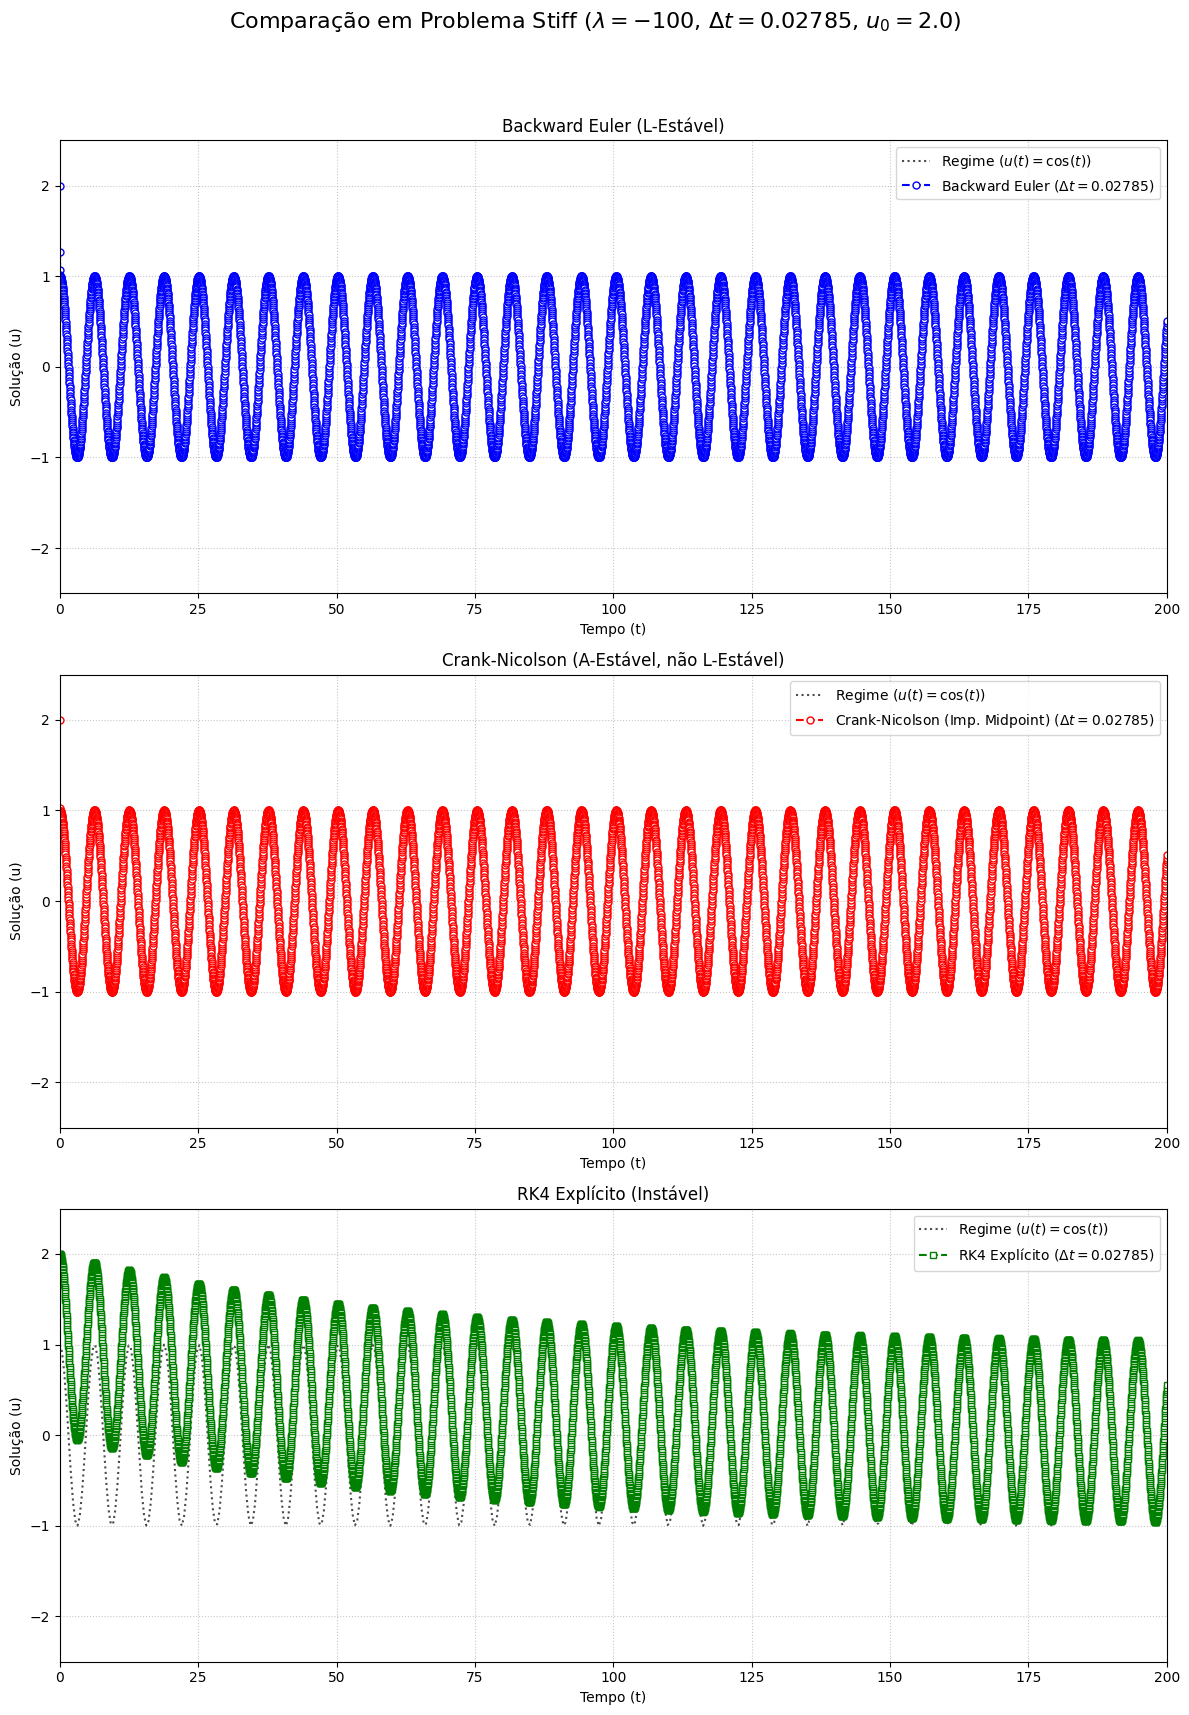


--- Tabela de Comparação de Erros (RMS e Max) ---
Parâmetros: lambda = -100, dt = 0.02785, u0 = 2.0, T = 200.0

           Método  Erro Max [0-200]  RMS [0-10]  RMS [10-20]  RMS [20-30]  RMS [30-40]  RMS [40-50]  RMS [50-60]  RMS [60-70]  RMS [70-80]  RMS [80-90]  RMS [90-100]  RMS [100-110]  RMS [110-120]  RMS [120-130]  RMS [130-140]  RMS [140-150]  RMS [150-160]  RMS [160-170]  RMS [170-180]  RMS [180-190]  RMS [190-200]
0  Backward Euler          2.02e-01    1.13e-02     9.81e-05     9.58e-05     9.67e-05     9.96e-05     1.01e-04     9.95e-05     9.66e-05     9.59e-05      9.81e-05       1.01e-04       1.01e-04       9.79e-05       9.58e-05       9.68e-05       9.98e-05       1.01e-04       9.92e-05       9.64e-05       9.60e-05
1  Crank-Nicolson          2.26e-01    1.20e-02     6.83e-05     6.67e-05     6.74e-05     6.94e-05     7.04e-05     6.93e-05     6.73e-05     6.68e-05      6.84e-05       7.02e-05       7.00e-05       6.82e-05       6.67e-05       6.74e-05       6.95e-05

In [8]:
if __name__ == "__main__":
    
    # 1. Definição do Problema Stiff
    lmbda = -100  # Parâmetro de rigidez

    def f_stiff(t, u):
        cos_t = np.cos(t)
        sin_t = np.sin(t)
        u_val = u[0] if isinstance(u, (np.ndarray, list)) else u
        return np.array([lmbda * (u_val - cos_t) - sin_t])

    # 2. Configuração da Simulação (Parâmetros das imagens)
    u0 = 2.0
    t_span = [0, 200.0]  # Intervalo de tempo longo
    dt = 0.02785            
    
    def u_exact(t, u0_val, lmbda_val):
        return np.cos(t) + (u0_val - 1) * np.exp(lmbda_val * t)

    # 3. Resolver com Backward Euler (L-Estável)
    solver_be = BackwardEuler(f_stiff)
    solver_be.set_initial_condition(u0)
    t_be, u_be = solver_be.solve(t_span, dt)

    # 4. Resolver com Crank-Nicolson / Implicit Midpoint (A-Estável)
    solver_cn = ImplicitMidpoint(f_stiff)
    solver_cn.set_initial_condition(u0)
    t_cn, u_cn = solver_cn.solve(t_span, dt)

    # 5. Resolver com RK4 (Explícito - Instável)
    solver_rk4 = RK4(f_stiff)
    solver_rk4.set_initial_condition(u0)
    t_rk4, u_rk4 = solver_rk4.solve(t_span, dt)

    # 6. Solução exata para plotagem
    t_exato_plot = np.linspace(t_span[0], t_span[1], 500)
    u_exato_plot = u_exact(t_exato_plot, u0, lmbda)
    u_regime_plot = np.cos(t_exato_plot) # Solução de regime

    # 7. Gerar Gráficos (3x1)
    plt.figure(figsize=(12, 18))
    plt.suptitle(f"Comparação em Problema Stiff ($\lambda = {lmbda}$, $\Delta t = {dt}$, $u_0 = {u0}$)", fontsize=16)

    # Gráfico 1: Backward Euler
    plt.subplot(3, 1, 1)
    plt.plot(t_exato_plot, u_regime_plot, 'k:', label='Regime ($u(t) = \cos(t)$)', linewidth=1.5, alpha=0.7)
    plt.plot(t_be, u_be, 'bo--', label=f'Backward Euler ($\Delta t={dt}$)', markersize=5, mfc='white')
    plt.title("Backward Euler (L-Estável)")
    plt.xlabel("Tempo (t)")
    plt.ylabel("Solução (u)")
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.xlim(0, 200)
    plt.ylim(-2.5, 2.5) # Limite fixo para mostrar estabilidade

    # Gráfico 2: Crank-Nicolson
    plt.subplot(3, 1, 2)
    plt.plot(t_exato_plot, u_regime_plot, 'k:', label='Regime ($u(t) = \cos(t)$)', linewidth=1.5, alpha=0.7)
    plt.plot(t_cn, u_cn, 'ro--', label=f'Crank-Nicolson (Imp. Midpoint) ($\Delta t={dt}$)', markersize=5, mfc='white')
    plt.title("Crank-Nicolson (A-Estável, não L-Estável)")
    plt.xlabel("Tempo (t)")
    plt.ylabel("Solução (u)")
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.xlim(0, 200)
    plt.ylim(-2.5, 2.5) # Limite fixo para mostrar oscilações

    # Gráfico 3: RK4 Explícito
    plt.subplot(3, 1, 3)
    plt.plot(t_exato_plot, u_regime_plot, 'k:', label='Regime ($u(t) = \cos(t)$)', linewidth=1.5, alpha=0.7)
    plt.plot(t_rk4, u_rk4, 'gs--', label=f'RK4 Explícito ($\Delta t={dt}$)', markersize=5, mfc='white')
    plt.title("RK4 Explícito (Instável)")
    plt.xlabel("Tempo (t)")
    plt.ylabel("Solução (u)")
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.ylim(-2.5, 2.5) # Limite maior para mostrar o início da divergência
    plt.xlim(0, 200)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 8. Análise de Erro com Pandas
    print("\n" + "="*80)
    print("--- Tabela de Comparação de Erros (RMS e Max) ---")
    print(f"Parâmetros: lambda = {lmbda}, dt = {dt}, u0 = {u0}, T = {t_span[1]}")
    print("="*80 + "\n")
    
    # Gera a solução exata nos mesmos pontos de tempo da simulação
    u_exact_pontos = u_exact(t_be, u0, lmbda)
    
    # Define os intervalos
    intervals = [(i, i + 10) for i in range(0, 200, 10)]
    data = []
    
    solvers_data = [
        ("Backward Euler", u_be),
        ("Crank-Nicolson", u_cn),
        ("RK4 Explícito", u_rk4)
    ]
    
    for name, u_solution in solvers_data:
        # Calcula o erro absoluto
        error = np.abs(u_solution - u_exact_pontos)
        
        # Substitui inf por NaN para cálculos estatísticos
        error[~np.isfinite(error)] = np.nan
        
        row = {"Método": name}
        
        # Erro Máximo no intervalo total
        row["Erro Max [0-200]"] = np.nanmax(error)
        
        # Calcula Erro RMS para cada intervalo
        for t_start, t_end in intervals:
            # Encontra índices dentro do intervalo
            # (Nota: t_be <= t_end inclui o ponto final)
            indices = (t_be >= t_start) & (t_be <= t_end)
            
            # Garante que temos dados no intervalo
            if np.any(indices):
                error_interval = error[indices]
                # Calcula RMS (Root Mean Square Error)
                rms_error = np.sqrt(np.nanmean(error_interval**2))
                row[f"RMS [{t_start}-{t_end}]"] = rms_error
            else:
                row[f"RMS [{t_start}-{t_end}]"] = np.nan
        
        data.append(row)
        
    # Cria e exibe o DataFrame
    df = pd.DataFrame(data)
    
    # Configurações do pandas para melhor exibição no console
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.float_format', '{:,.2e}'.format) # Formato científico

    print(df.to_string())